# Temporal brain gene expression trajectory

[BrainSpan](https://www.brainspan.org/) RNA-seq data is downloaded from http://development.psychencode.org and temporal gene expression is probed for genes of interest.

### Download data and metadata

In [1]:
rm(list = ls())
options(stringsAsFactors = FALSE)

suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(data.table)))
library(readxl)

system("curl http://development.psychencode.org/files/raw_data/mRNA-seq_Sample%20metadata.xlsx --output metadata_subject.xlsx")
system("curl http://development.psychencode.org/files/processed_data/RNA-seq/mRNA-seq_QC.xlsx --output metadata_sample.xlsx")
system("curl http://development.psychencode.org/files/processed_data/RNA-seq/mRNA-seq_hg38.gencode21.wholeGene.geneComposite.STAR.nochrM.gene.RPKM.normalized.CQNCombat.txt --output data_normalized.txt")

### Munge metadata

In [2]:
datMeta_subject <- read_excel("metadata_subject.xlsx", skip = 3)
datMeta_subject <- slice(datMeta_subject, -1)
#datMeta_subject %>% print(n = 5, width = Inf)

datMeta_sample <- read_excel("metadata_sample.xlsx", skip = 3)
#datMeta_sample %>% print(n = 5, width = Inf)
datMeta_sample <- slice(datMeta_sample, -1) %>% 
  select(2:3) %>% 
  unite(ID, c(Braincode, Regioncode), sep = ".", remove = FALSE)

datMeta <- left_join(datMeta_sample, datMeta_subject, by = "Braincode")  # 607 samples

New names:
* `` -> ...11
* `` -> ...12
* `` -> ...14
* `` -> ...16
* `` -> ...17
* ...



In [3]:
datMeta <- datMeta %>% 
  mutate(Region = ifelse(Regioncode %in% c("DFC", "MFC", "PC", "VFC", "M1C", "OFC", "FC"), "Frontal Cortex",
                        ifelse(Regioncode %in% c("A1C", "ITC", "STC", "TC"), "Temporal Cortex",
                               ifelse(Regioncode %in% c("IPC", "S1C", "PC"), "Parietal Cortex",
                                      ifelse(Regioncode %in% c("OC", "V1C"), "Visual Cortex",
                                             ifelse(Regioncode %in% c("CB", "CBC", "URL"), "Cerebellum",
                                                    ifelse(Regioncode %in% c("DTH", "MD", "DIE"), "Thalamus",
                                                           ifelse(Regioncode %in% c("CGE", "LGE" ,"MGE", "STR"), "Striatum",
                                                                  ifelse(Regioncode == "HIP", "Hippocampus", 
                                                                         ifelse(Regioncode == "AMY","Amygdala", NA))))))))))

datMeta <- mutate(datMeta, Period = ifelse(Days < 40 * 7, "Prenatal", "Postnatal"))
datMeta$Period = factor(datMeta$Period, levels = c("Prenatal", "Postnatal"))
#datMeta %>% print(n = nrow(.), width = Inf)

### Munge expression data

In [4]:
expr <- as.data.frame(fread("data_normalized.txt"))
rownames(expr) <- expr$Geneid
expr <- select(expr, -1)  # 60,155 x 607

annot <- data.frame(Geneid = rownames(expr))
annot[, c("ENSG", "gene")] <- str_split_fixed(annot$Geneid,"[|]", 2)

ind <- match(colnames(expr), datMeta$ID)
#sum(is.na(ind))
datMeta <- datMeta[ind, ]

### Plot developmental gene expression

In [5]:
plot_expr <- function(gene) {
    ind <- which(annot$gene == gene)
    data.frame(RPKM = as.numeric(expr[ind, ]), datMeta) %>% 
      filter(!is.na(Region)) %>% 
      ggplot(aes(x = Days, y = log2(.1 + RPKM), fill = Region, color = Region)) +
        geom_point(aes(shape = Sex)) + 
        scale_x_log10() +
        geom_smooth(alpha = .1, span = 1, se = FALSE) + 
        labs(x = "Days post conception") + 
        ggtitle(annot$gene[ind]) +
        theme_bw() +
        theme(plot.title = element_text(hjust = .5), panel.grid = element_blank()) +
        geom_vline(xintercept = 40 * 7, lty = 1) # + facet_grid(~ Period, scales = "free_x")
}

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



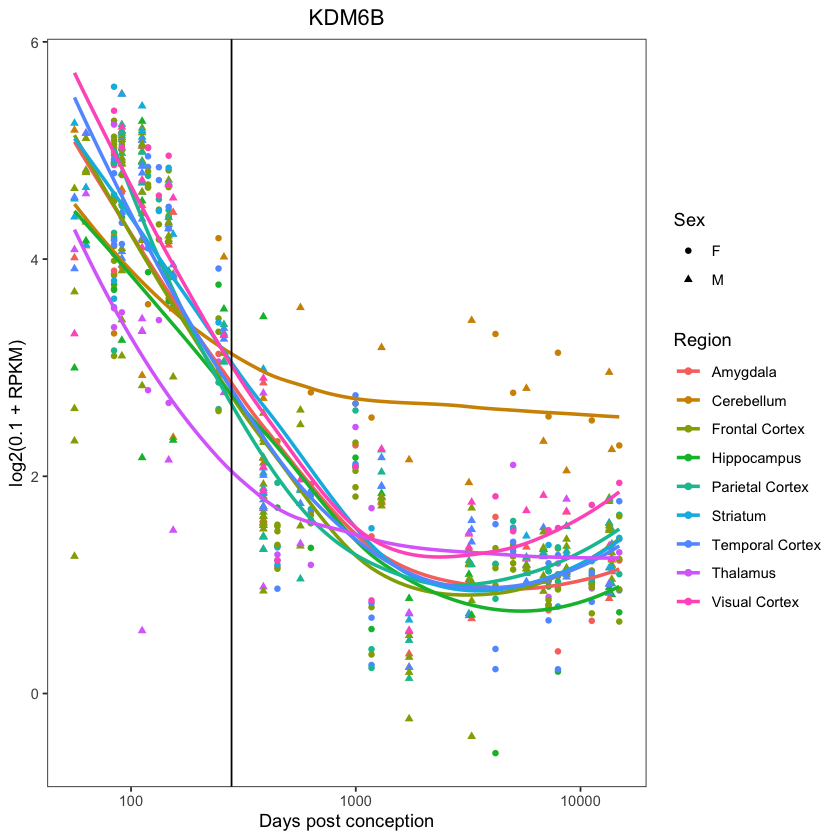

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



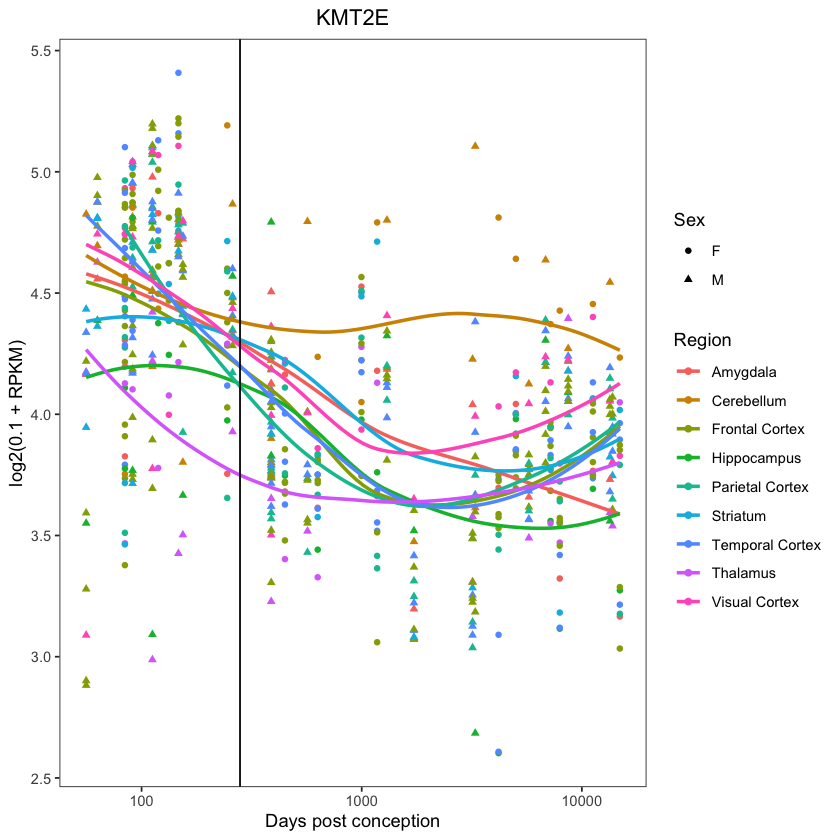

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



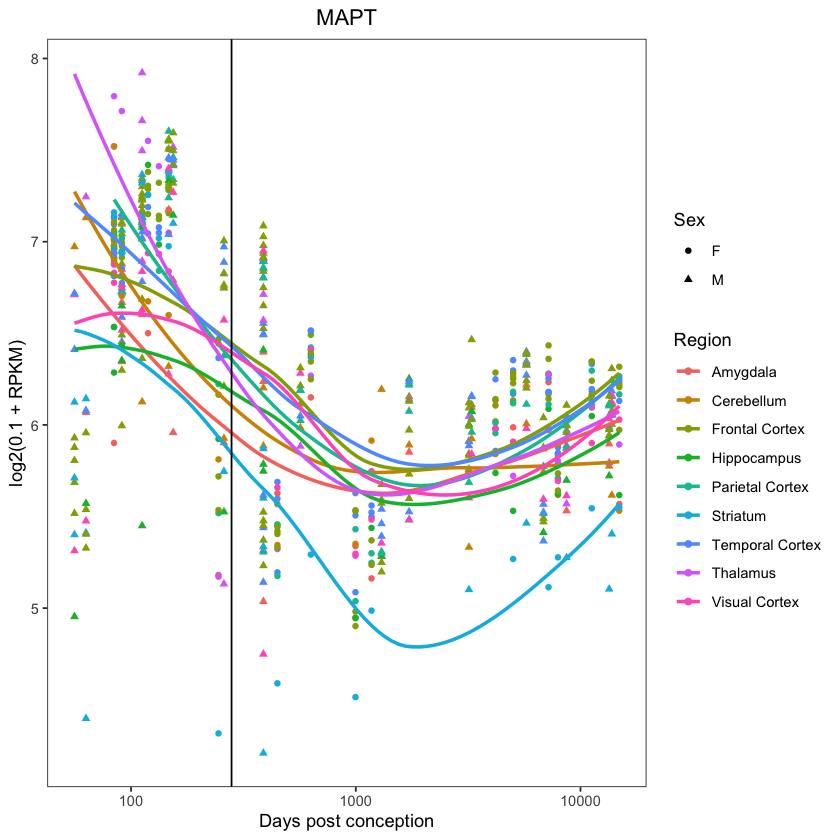

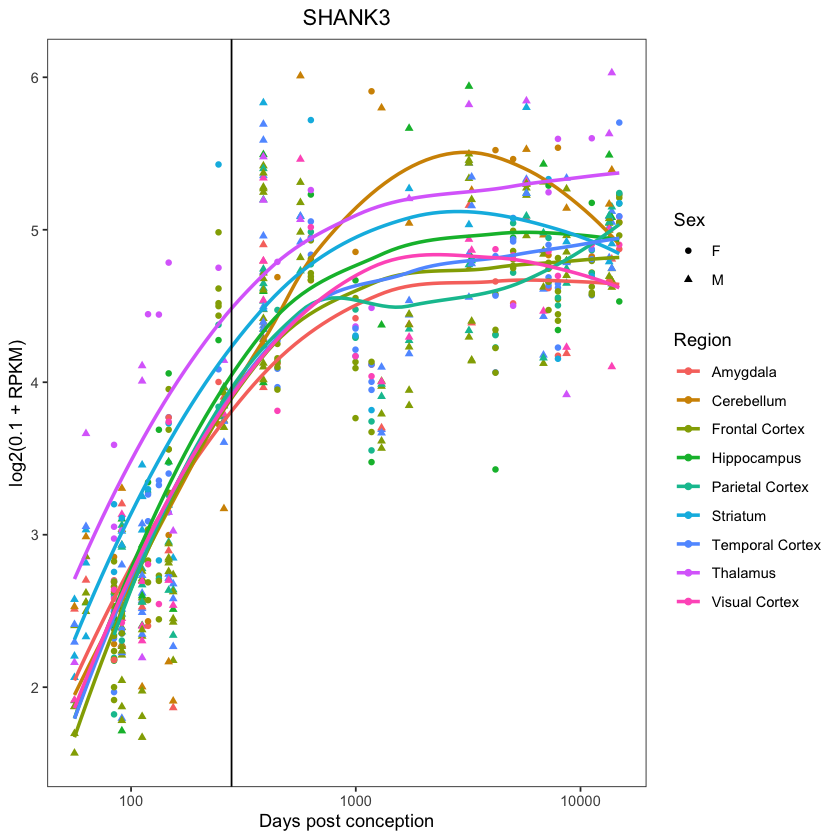

In [6]:
plot_expr("KDM6B")
plot_expr("KMT2E")
plot_expr("MAPT")
plot_expr("SHANK3")

Post-synaptic density (PSD), chromatin or epigenetic modifiers, cytoskeleon, and channel protein genes are implicated in a range of neuopsychiatric disorders such as Autism Spectrum Disorder (ASD) and schizophrenia. These genes exhibit varying levels of expression during neurodevelopment as seen above.